In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras import regularizers

# Load the CSV file
file_path = 'Crowd data for anomaly detection.csv'
data = pd.read_csv(file_path)

# Selecting relevant columns
features = ['Density', 'LevelOfCrowdness', 'Speed']
target = 'label'

# Splitting data into features and target
X = data[features]
y = data[target]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the autoencoder model
input_dim = X_scaled.shape[1]
encoding_dim = 2  # Number of dimensions to compress to

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu",
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
decoder = Dense(input_dim, activation='linear')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(X_scaled, X_scaled, epochs=100, batch_size=32, shuffle=True, validation_split=0.2, verbose=0)

# Extract the encoder part of the autoencoder
encoder_model = Model(inputs=input_layer, outputs=encoder)

# Get the compressed representation of the data
X_compressed = encoder_model.predict(X_scaled)

# Splitting compressed data into training and testing sets
X_train_compressed, X_test_compressed, y_train, y_test = train_test_split(X_compressed, y, test_size=0.3, random_state=42)


754/754 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Isolation Forest Accuracy: 0.72
Isolation Forest Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.99      0.83      5065
           1       0.76      0.09      0.15      2172

    accuracy                           0.72      7237
   macro avg       0.74      0.54      0.49      7237
weighted avg       0.73      0.72      0.63      7237



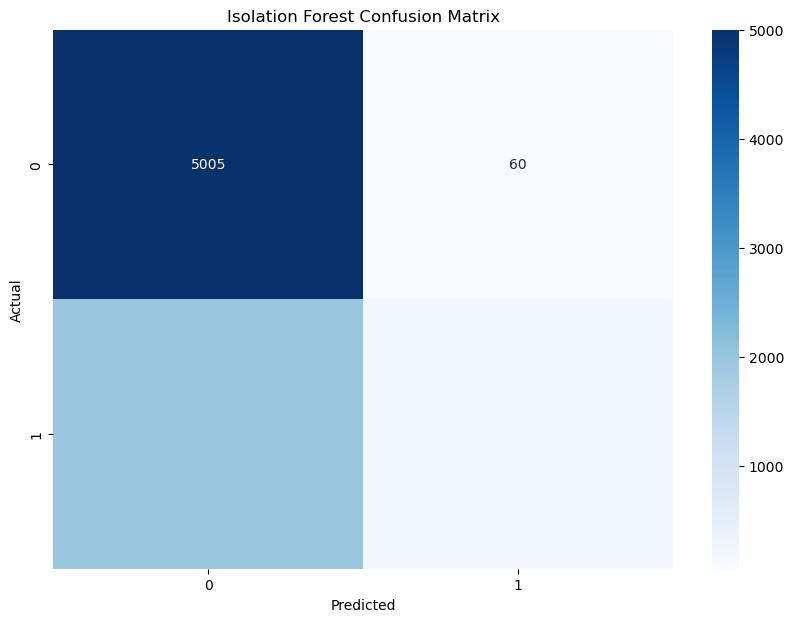

In [4]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train the Isolation Forest model
iso_forest = IsolationForest(contamination=0.03, random_state=42)
iso_forest.fit(X_train_compressed)

# Predict the outliers in the test set
y_pred_train = iso_forest.predict(X_train_compressed)
y_pred_test = iso_forest.predict(X_test_compressed)

# Convert predictions to binary labels (1 for normal, -1 for outliers)
y_pred_train = np.where(y_pred_train == 1, 0, 1)
y_pred_test = np.where(y_pred_test == 1, 0, 1)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_report = classification_report(y_test, y_pred_test)

print(f'Isolation Forest Accuracy: {accuracy:.2f}')
print("Isolation Forest Classification Report:")
print(class_report)

# Visualizing the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Isolation Forest Confusion Matrix')
plt.savefig('IsolationForest_confusion_matrix_ENCOD.png')
plt.show()


In [6]:
# Calculate the decision function scores
anomaly_scores = -iso_forest.predict_proba(X_test_compressed)[:, 1]

# Set a threshold to identify anomalies
threshold = np.percentile(anomaly_scores, 95)
anomalies = np.where(anomaly_scores > threshold)[0]

# Visualizing anomalies
plt.figure(figsize=(10, 7))
plt.scatter(X_test_compressed[:, 0], X_test_compressed[:, 1], c='blue', label='Normal Data')
plt.scatter(X_test_compressed[anomalies, 0], X_test_compressed[anomalies, 1], c='red', label='Anomalies')
plt.xlabel('Compressed Feature 1')
plt.ylabel('Compressed Feature 2')
plt.title('Anomalies in Compressed Data')
plt.legend()
plt.savefig('/mnt/data/DecisionTree_anomalies.png')
plt.show()

print(f'Number of anomalies detected: {len(anomalies)}')


AttributeError: 'IsolationForest' object has no attribute 'predict_proba'